In [8]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import scipy
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import json
from matplotlib.collections import PatchCollection

In [7]:
# Single subject parameters and data locations
parent_dir = '/Users/molly/Documents/code'
timeseries_csv = ('/Users/molly/Documents/code/13281_2016-10-14_rois_timeseries.csv')
network_json_path = '/Users/molly/Documents/code/connectiviz/data/Yeo_7network_names.json'
subregions_csv = '/Users/molly/Documents/code/connectiviz/data/subregions_Yeo7networks.csv'

In [6]:
def create_mapped_timeseries(original_timeseries, network_name, network_dictionary, subregions):
     """
     Parameters:
     - Reads a JSON file (network_dictionary) containing network names (Yeo_7network_names)
     - Reads a CSV file (subregions) containing network labels and their mappings (network_mapping)
     - Maps the values in the first column of the original_timeseries based on the network labels and stores the result in mapped_timeseries
     - Creates new_timeseries by selecting columns from the 5th column onward from the original_timeseries
     - Adds the mapped timeseries as a new column named with the provided network_name
     - Extracts unique values from the 'Yeo_7network' column of the new_timeseries and stores them in yeo_networks
     Returns:
     - new_timeseries
     - yeo_networks
     - loaded Yeo_7network_names
     """
     # Import network dictionary
     with open(network_dictionary) as file:
         Yeo_7network_names = json.load(file)
     networks = pd.read_csv(subregions)
     network_mapping = networks.set_index('Label')[f'{network_name}'].to_dict()
     mapped_timeseries = original_timeseries.iloc[:, 0].map(network_mapping)
     new_timeseries = original_timeseries.iloc[:, 4:]
     new_timeseries[f'{network_name}'] = mapped_timeseries
     yeo_networks = new_timeseries['Yeo_7network'].unique()
     return new_timeseries, yeo_networks, Yeo_7network_names

In [5]:
def load_network_names(json_filepath):
    """
    Loads the network names from a JSON file and converts keys from strings to integers
    """
    with open(json_filepath, 'r') as file:
        data = json.load(file)
        return {int(k): v for k, v in data.items()}

### Intra-Network and Inter-Network Connectivity

In [4]:
#Intra-Network Connectivity
def calculate_intra_network_connectivity(original_timeseries, new_timeseries, network_json_path):
    """
    Intra-Network Connectivity

    Inputs:
    - orginal single-subject timeseries
    - new timeseries (discarding the first four columns of orig_timeseries and adding a new column with the mapped values of network labels)
    - path to the network names
    
    Parameters:
    - Key of network numbers mapped to network names
    - For each network, it selects the relevant data from original_timeseries based on the network labels in new_timeseries['Yeo_7network']
    - Calculates the correlation matrix for the selected data using network_data.transpose().corr() then gets the average correlations

    Returns:
    - Intra-network connectivity average correlation matrix
    """
    network_names = load_network_names(network_json_path)
    intra_network_connectivity = {}
    ordered_networks = network_names.keys()
    for network in ordered_networks:
        if network != 0:
            network_data = original_timeseries[new_timeseries['Yeo_7network'] == network]
            correlation_matrix = network_data.transpose().corr()
            average_corr = np.mean(correlation_matrix.values[np.triu_indices_from(correlation_matrix, k=1)])
            intra_network_connectivity[network] = average_corr
    return intra_network_connectivity

#Inter-Network Connectivity
def calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path):
    """
    Inter-Network Connectivity
    
    Inputs:
    - orginal single-subject timeseries
    - new timeseries
    - path to the network names

    Parameters:
    - Key of network numbers mapped to network names (ordered_networks)
    - Iterates over pairs of networks (network_i, network_j)
    - For each network pair, it selects the relevant data from original_timeseries based on the network labels in new_timeseries['Yeo_7network']
    - Calculates the correlation between each pair of rows (one from each network) and then gets the average correlations

    Returns:
    - Inter-network connectivity average correlation matrix
    """
    inter_network_connectivity = {}
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()
    for i, network_i in enumerate(ordered_networks):
        for j, network_j in enumerate(ordered_networks):
            if network_i != network_j and network_i != 0 and network_j != 0:
                data_i = original_timeseries[new_timeseries['Yeo_7network'] == network_i]
                data_j = original_timeseries[new_timeseries['Yeo_7network'] == network_j]
                correlation_values = []
                for index_i, row_i in data_i.iterrows():
                    for index_j, row_j in data_j.iterrows():
                        correlation_values.append(row_i.corr(row_j))
                average_corr = np.mean(correlation_values)
                key = (network_i, network_j)
                inter_network_connectivity[key] = average_corr
    return inter_network_connectivity

In [3]:
def plot_inter_intra_network_connectivity(intra_network_connectivity, inter_network_connectivity, ordered_networks, network_json_path):
    """
    Plots Inter/Intra-Network Connectivity

    Inputs:
    - Average correlation matrix of intra-network connectivity
    - Average correlation matrix of inter-network connectivity
    - Key of network numbers mapped to network names
    - Path to the network names JSON file (Yeo 7 networkds commonly used)

    Parameters:
    - Subplot with two axes (ax1 and ax2) is created for intra-network and inter-network connectivity
    - Horizontal bar plot (barh) is created for intra-network connectivity in ax1
    - Heatmap is created for inter-network connectivity in ax2

    Returns:
    - Combined plot of Intra and Inter-network connectivity with the networks and network names
    """
    matrix_df = pd.DataFrame(np.zeros((len(ordered_networks), len(ordered_networks))), index=ordered_networks, columns=ordered_networks)
    for key, value in inter_network_connectivity.items():
        network_i, network_j = key
        matrix_df.loc[network_i, network_j] = value
        matrix_df.loc[network_j, network_i] = value
    if 0 in matrix_df.index:
        matrix_df.drop(0, axis=0, inplace=True)
        matrix_df.drop(0, axis=1, inplace=True)
    mask = np.triu(np.ones_like(matrix_df, dtype=bool))
    
    Yeo_7network_names = load_network_names(network_json_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [0.4, 1]})

    
    network_labels = [Yeo_7network_names.get(network, f'Network {network}') for network in matrix_df.index]
    intra_network_values = [intra_network_connectivity[network] for network in matrix_df.index]

    ax1.barh(network_labels, intra_network_values, color='blue')
    ax1.set_title('Intra-Network Connectivity')
    ax1.set_xlim(0, max(intra_network_connectivity.values()) + 0.1)
    ax1.set_xlabel('Average Correlation')
    ax1.grid(axis='x')
    sns.heatmap(matrix_df, cmap="coolwarm", annot=True, linewidths=.5, mask=mask, ax=ax2, cbar_kws={"shrink": 0.8})
    ax2.set_xticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_xticklabels(network_labels, rotation=45)
    ax2.set_yticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_yticklabels(network_labels, rotation=0)
    ax2.set_title("Inter-Network Connectivity")
    plt.tight_layout()
    plt.show()

In [2]:
def calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path):
    """
    Single Subject Plot of Intra/Inter-Network Connectivity with Network Subregions and Names

    Inputs:
    - original timerseries
    - networks (subregions) and network names

    Parameters:
    - Reads a CSV file containing time series data (timeseries_csv)
    - Drops a specific column from the read data (column 233)
    - Reads a CSV file containing information about network labels and their corresponding regions (subregions_csv)
    - Loads network names from a JSON file (network_json_path)
    - Maps the network labels in the time series data based on the information in subregions_csv
    - Creates a new timeseries (new_timeseries) by dropping the first four columns of the original timeseries and adding a new column for the mapped network labels
    - Calculates Intra and Inter-Network Connectivity
    - Plots Both Intra and Inter-Network Connectivity

    Returns:
    - Plot of both Intra and Inter-network connectivity with the networks and network names
    """
    original_timeseries = pd.read_csv(timeseries_csv)
    original_timeseries = original_timeseries.drop(original_timeseries.columns[233], axis=1)

    networks = pd.read_csv(subregions_csv)
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()
    network_mapping = networks.set_index('Label')['Yeo_7network'].to_dict()
    mapped_timeseries = original_timeseries.iloc[:, 0].map(network_mapping)
    new_timeseries = original_timeseries.iloc[:, 4:]
    new_timeseries['Yeo_7network'] = mapped_timeseries
    original_timeseries = original_timeseries.iloc[:, 4:]

    # Intra-Network Connectivity
    intra_network_connectivity = calculate_intra_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Inter-Network Connectivity
    inter_network_connectivity = calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Both plots
    plot_inter_intra_network_connectivity(intra_network_connectivity, inter_network_connectivity, ordered_networks, network_json_path)


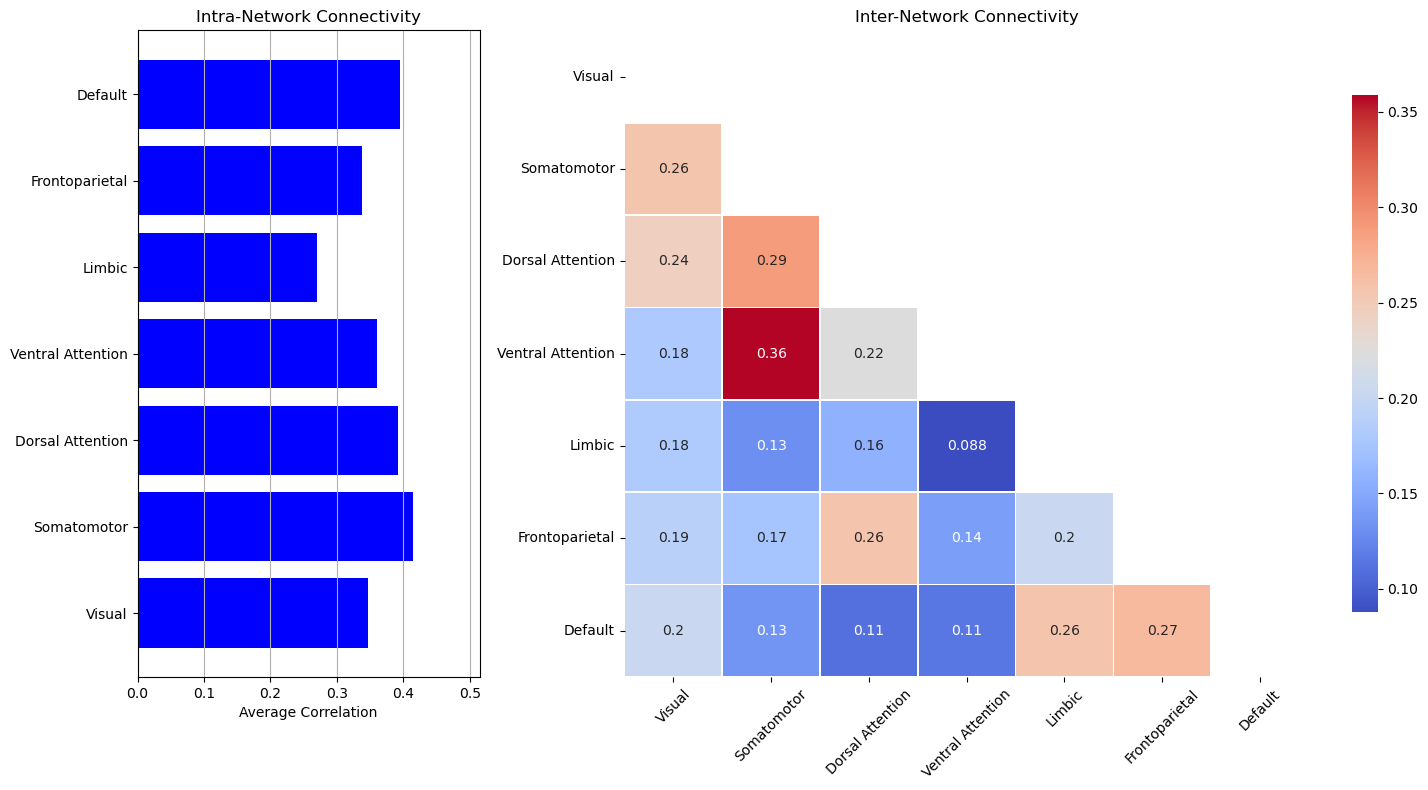

In [9]:
# Calculates and Plots Intra/Inter Network Connectivity
calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path)

In [27]:
def molly_plot_inter_intra_network_connectivity(intra_network_connectivity, molly_inter_network_connectivity, ordered_networks, network_json_path):
    matrix_df = pd.DataFrame(np.zeros((len(ordered_networks), len(ordered_networks))), index=ordered_networks, columns=ordered_networks)
    for key, value in molly_inter_network_connectivity.items():
        network_i, network_j = key
        matrix_df.loc[network_i, network_j] = value
        matrix_df.loc[network_j, network_i] = value
    if 0 in matrix_df.index:
        matrix_df.drop(0, axis=0, inplace=True)
        matrix_df.drop(0, axis=1, inplace=True)
    mask = np.triu(np.ones_like(matrix_df, dtype=bool))
    
    Yeo_7network_names = load_network_names(network_json_path)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [0.4, 1]})

    
    network_labels = [Yeo_7network_names.get(network, f'Network {network}') for network in matrix_df.index]
    intra_network_values = [intra_network_connectivity[network] for network in matrix_df.index]

    ax1.barh(network_labels, intra_network_values, color='blue')
    ax1.set_title('Intra-Network Connectivity')
    ax1.set_xlim(0, max(intra_network_connectivity.values()) + 0.1)
    ax1.set_xlabel('Average Correlation')
    ax1.grid(axis='x')
    sns.heatmap(matrix_df, cmap="coolwarm", annot=True, linewidths=.5, mask=mask, ax=ax2, cbar_kws={"shrink": 0.8})
    ax2.set_xticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_xticklabels(network_labels, rotation=45)
    ax2.set_yticks(np.arange(0.5, len(matrix_df.index)))
    ax2.set_yticklabels(network_labels, rotation=0)
    ax2.set_title("Inter-Network Connectivity")
    plt.tight_layout()
    plt.show()

In [26]:
def molly_calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path):
    original_timeseries = pd.read_csv(timeseries_csv)
    original_timeseries = original_timeseries.drop(original_timeseries.columns[233], axis=1)

    networks = pd.read_csv(subregions_csv)
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()
    network_mapping = networks.set_index('Label')['Yeo_7network'].to_dict()
    mapped_timeseries = original_timeseries.iloc[:, 0].map(network_mapping)
    new_timeseries = original_timeseries.iloc[:, 4:]
    new_timeseries['Yeo_7network'] = mapped_timeseries
    original_timeseries = original_timeseries.iloc[:, 4:]

    # Intra-Network Connectivity
    intra_network_connectivity = calculate_intra_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Inter-Network Connectivity
    molly_inter_network_connectivity = molly_calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path)
    # Both plots
    plot_inter_intra_network_connectivity(intra_network_connectivity, molly_inter_network_connectivity, ordered_networks, network_json_path)

In [28]:
def molly_calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path):
    molly_inter_network_connectivity = {}
    network_names = load_network_names(network_json_path)
    ordered_networks = network_names.keys()

    # Create an empty correlation matrix and connection count matrix
    correlation_matrix = np.zeros((len(ordered_networks), len(ordered_networks)))
    connection_count_matrix = np.zeros((len(ordered_networks), len(ordered_networks)))

    for i, network_i in enumerate(ordered_networks):
        for j, network_j in enumerate(ordered_networks):
            if network_i != network_j and network_i != 0 and network_j != 0:
                data_i = original_timeseries[new_timeseries['Yeo_7network'] == network_i]
                data_j = original_timeseries[new_timeseries['Yeo_7network'] == network_j]

                # Calculate the number of connections
                connection_count = len(data_i) * len(data_j)

                # Calculate the average correlation
                if connection_count > 0:
                    correlation_values = [row_i.corr(row_j) for _, row_i in data_i.iterrows() for _, row_j in data_j.iterrows()]
                    average_corr = np.mean(correlation_values)
                    key = (network_i, network_j)
                    molly_inter_network_connectivity[key] = average_corr

                    # Update the correlation matrix and connection count matrix
                    correlation_matrix[i, j] = average_corr
                    connection_count_matrix[i, j] = connection_count

    # Call the function to visualize the correlation matrix with circles using coolwarm colormap
    visualize_correlation_matrix_with_circles(correlation_matrix, connection_count_matrix, ordered_networks, cmap=plt.get_cmap('coolwarm'))

    return molly_inter_network_connectivity
def visualize_correlation_matrix_with_circles(correlation_matrix, connection_count_matrix, ordered_networks, cmap='coolwarm'):
    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Plot the correlation matrix as a heatmap with a colorbar
    sns.heatmap(correlation_matrix, cmap='coolwarm', annot=True, fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation'})

    # Add circles to represent correlation strength with colors and sizes based on connection count
    for i in range(len(ordered_networks)):
        for j in range(len(ordered_networks)):
            # Skip diagonal elements
            if i == j:
                continue
            
            # Draw circles with radius proportional to the connection count
            circle_radius = connection_count_matrix[i, j] * 0.1  # Adjust the scaling factor as needed
            color = cmap(correlation_matrix[i, j])
            ax.add_patch(plt.Circle((j + 0.5, i + 0.5), circle_radius, color=color, edgecolor='black'))

    # Set x and y axis labels
    ax.set_xticks(np.arange(len(ordered_networks)) + 0.5)
    ax.set_yticks(np.arange(len(ordered_networks)) + 0.5)
    ax.set_xticklabels(ordered_networks)
    ax.set_yticklabels(ordered_networks)

    # Set title
    ax.set_title('Correlation Matrix with Circles (Size based on Connection Count)')

    # Show the plot
    plt.show()

# Assuming you have a function named 'load_network_names'
# Example usage:
molly_calculate_inter_network_connectivity(original_timeseries, new_timeseries, network_json_path)


NameError: name 'original_timeseries' is not defined

In [18]:
molly_calculate_and_plot_inter_intra_network_connectivity(timeseries_csv, subregions_csv, network_json_path)

TypeError: plot_inter_intra_network_connectivity() takes 4 positional arguments but 5 were given